In [134]:
import pandas as pd
import numpy as np
import rebound
import matplotlib.pyplot as plt
from matplotlib import colors
from rebound.interruptible_pool import InterruptiblePool
import scipy.optimize as opt

In [135]:
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict
from celmech.disturbing_function import laplace_b as b

In [136]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [137]:
def StoG(mass, amp, phi):
    m1, m3 = mass
    A1, A2, A3 = amp
    p1, p2, p3 = phi
    
    e1_x = 1/np.sqrt(m1)*(np.sqrt(m1/(m1+m3))*A1*np.cos(p1) - np.sqrt(m3/(m1+m3))*A2*np.cos(p2))
    e2_x = 1/np.sqrt(m1+m3)*A1*np.cos(p1) - A3*np.cos(p3)
    e3_x = 1/np.sqrt(m3)*(np.sqrt(m3/(m1+m3))*A1*np.cos(p1) + np.sqrt(m1/(m1+m3))*A2*np.cos(p2))
    
    e1_y = 1/np.sqrt(m1)*(np.sqrt(m1/(m1+m3))*A1*np.sin(p1) - np.sqrt(m3/(m1+m3))*A2*np.sin(p2))
    e2_y = 1/np.sqrt(m1+m3)*A1*np.sin(p1) - A3*np.sin(p3)
    e3_y = 1/np.sqrt(m3)*(np.sqrt(m3/(m1+m3))*A1*np.sin(p1) + np.sqrt(m1/(m1+m3))*A2*np.sin(p2))
    
    e1, e2, e3 = np.sqrt(e1_x**2 + e1_y**2), np.sqrt(e2_x**2 + e2_y**2), np.sqrt(e3_x**2 + e3_y**2)
    pom1, pom2, pom3 = np.arctan2(e1_y,e1_x), np.arctan2(e2_y,e2_x), np.arctan2(e3_y,e3_x)
    
    return (e1, e2, e3), (pom1, pom2, pom3)

In [138]:
def GtoS(alpha, mass, ecc, pomega):
    alpha12, alpha23 = alpha
    alpha13 = alpha12*alpha23
    m1, m3 = mass
    ecc1, ecc2, ecc3 = ecc
    pom1, pom2, pom3 = pomega

    e1_x, e2_x, e3_x = ecc1*np.cos(pom1), ecc2*np.cos(pom2), ecc3*np.cos(pom3)
    e1_y, e2_y, e3_y = ecc1*np.sin(pom1), ecc2*np.sin(pom2), ecc3*np.sin(pom3)
    
    amp1 = 1/np.sqrt(m1+m3) * np.sqrt((m1*e1_y + m3*e3_y)**2 + (m1*e1_x + m3*e3_x)**2)
    amp2 = np.sqrt(m1*m3/(m1+m3)) * np.sqrt((e3_y-e1_y)**2 + (e3_x-e1_x)**2)
    amp3 = 1/(m1+m3) * np.sqrt((m3*(e3_y-e2_y)-m1*(e2_y-e1_y))**2+(m3*(e3_x-e2_x)-m1*(e2_x-e1_x))**2)
    
    phase1 = np.arctan2(m1*e1_y+m3*e3_y, m1*e1_x+m3*e3_x)
    phase2 = np.arctan2(e3_y-e1_y, e3_x-e1_x)
    phase3 = np.arctan2(m3*(e3_y-e2_y)-m1*(e2_y-e1_y), m3*(e3_x-e2_x)-m1*(e2_x-e1_x))
    
    omega2 = (alpha12+alpha13+alpha23)/3 * (m1+m3)/(2*(1-alpha13)**2)
    omega3 = (alpha12+alpha13+alpha23)/3 * (m1/(2*(1-alpha12)**2) + m3/(2*(1-alpha23)**2))
    
    return amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3

In [139]:
def breathingON(mass, A3_p):
    m1, m3 = mass
    
    x1 = np.sqrt(m3/(m1*(m1+m3)))
    x2 = 1
    y1 = np.sqrt(m1/(m3*(m1+m3)))
    y2 = 1

    if m1==m3:
        A3_b = A3_p / np.sqrt(2)
        A2_b = A3_b*x2/x1
        theta = np.pi/2
    else:
        def A2(theta):
            return 2*A3_p*x2*y2*np.cos(theta) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2)
        def A3(theta):
            return A3_p*(x1*y2-x2*y1) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2)
        def e21_min(theta):
            return -(x1*A2(theta) + x2*A3(theta))**2
        def e32_min(theta):
            return -(y1*A2(theta) + y2*A3(theta))**2
        
        minimizer_kwargs = dict(method="L-BFGS-B", bounds=[(0,2*np.pi)])
        result21 = opt.basinhopping(e21_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        result32 = opt.basinhopping(e32_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        
        if np.fabs(result21.fun) > np.fabs(result32.fun):
            theta = result21.x
            A2_b, A3_b = A2(theta), A3(theta)
        else:
            theta = result32.x
            A2_b, A3_b = A2(theta), A3(theta)
    
    return A2_b, A3_b, theta

In [140]:
MASS = 3e-6, 3e-6
POMEGA = 0, 2*np.pi/3, -2*np.pi/3
f = 0.05
scale = 1e5

In [141]:
def simNoBreathing(alpha):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu3 = MASS
    ECC = f*(1-alpha12), f*(1-(alpha12+alpha23)/2), f*(1-alpha23)
    
    amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3,  = GtoS(alpha, MASS, ECC, POMEGA)
    ecc_nb, pomega_nb = StoG(MASS, (amp1, 0, amp3), (phase1, phase2, phase3))
    ecc1, ecc2, ecc3 = ecc_nb
    pomega1, pomega2, pomega3 = pomega_nb
    
    print(ecc_nb)
    print(pomega_nb)
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    Nout=400
    e21, e32 = np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(0,scale,Nout)
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1_x, e1_y = e1*np.cos(p1), e1*np.sin(p1)
            e2_x, e2_y = e2*np.cos(p2), e2*np.sin(p2)
            e3_x, e3_y = e3*np.cos(p3), e3*np.sin(p3)  
            
            e21[i] = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
            e32[i] = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
                       
        except rebound.Collision:
            break
    
    return e21, e32

In [142]:
def simWithBreathing(alpha):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu3 = MASS
    ECC = f*(1-alpha12), f*(1-(alpha12+alpha23)/2), f*(1-alpha23)
    
    amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3 = GtoS(alpha, MASS, ECC, POMEGA)   
    amp2_wb, amp3_wb, theta = breathingON(MASS, amp3)
    ecc_wb, pomega_wb = StoG(MASS, (amp1, amp2_wb, amp3_wb), (phase1, phase2, phase2+theta))
    
    ecc1, ecc2, ecc3 = ecc_wb
    pomega1, pomega2, pomega3 = pomega_wb
    
    print(ecc_wb)
    print(pomega_wb)
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    Nout=400
    e21, e32 = np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(0,scale,Nout)
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1_x, e1_y = e1*np.cos(p1), e1*np.sin(p1)
            e2_x, e2_y = e2*np.cos(p2), e2*np.sin(p2)
            e3_x, e3_y = e3*np.cos(p3), e3*np.sin(p3)  
            
            e21[i] = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
            e32[i] = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
                       
        except rebound.Collision:
            break
    
    return e21, e32

In [143]:
e12_nb, e23_nb = simNoBreathing((0.85, 0.85))
e12_wb, e23_wb = simWithBreathing((0.85, 0.85))

(0.003750000000000001, 0.0075, 0.003750000000000001)
(-1.0471975511965976, 2.0943951023931953, -1.0471975511965976)
(0.00879452954966893, 0.0042049512883486585, 0.00879452954966893)
(0.08308811259360027, 2.0943951023931953, -2.177483214986796)


Text(0.5, 0, 'time [$P_2$]')

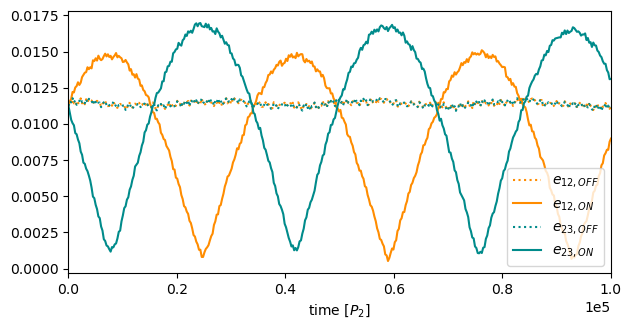

In [151]:
times = np.linspace(0,scale,400)

f, ax = plt.subplots(1, 1, figsize=(7,3.4))
ax.plot(times, e12_nb, color='darkorange', linestyle=':', label='$e_{12,OFF}$')
ax.plot(times, e12_wb, color='darkorange', linestyle='-', label='$e_{12,ON}$')
ax.plot(times, e23_nb, color='darkcyan', linestyle=':', label='$e_{23,OFF}$')
ax.plot(times, e23_wb, color='darkcyan', linestyle='-', label='$e_{23,ON}$')
ax.legend(loc="lower right", fontsize=10)
ax.set_xlim(0,scale)
ax.ticklabel_format(axis='x', style='sci', scilimits=(5,5))
ax.set_xlabel("time [$P_2$]")